# Amazon Bedrock Claude3
- Claude3이 되면서 기존 Claude2/2.1에서 사용하는 prompt 메시지 방식이 새롭게 개선되었습니다.
- 새로운 메시지 API는 아래와 같은 주요 이점을 제공합니다:
  - 이미지 처리: 메시지 API는 Claude로 이미지를 처리할 수 있는 유일한 방법으로, 이미지 분류, 물체 감지 등과 같은 작업에 고급 컴퓨터 비전 기능을 활용할 수 있습니다.
  - Claude 3 모델로 구축하기: 가장 강력한 최신 Claude 3 모델은 메시지 API를 통해서만 호출할 수 있습니다. 업그레이드를 통해 향상된 성능과 기능을 활용할 수 있습니다.
  - 향상된 오류 처리: 메시지 API를 사용하면 더욱 유익하고 유용한 오류 메시지를 반환할 수 있으므로 요청의 문제를 더 쉽게 진단하고 해결할 수 있습니다.
  - 요청 유효성 검사 개선: 메시지 API를 사용하면 사용자의 API 요청을 보다 효과적으로 검증할 수 있으므로, 사용자가 모델에서 최고 품질의 결과와 최상의 성능을 얻을 수 있습니다.
- 참고 자료 
  - https://docs.anthropic.com/claude/docs/upgrading-from-the-text-completions-api
  - https://docs.anthropic.com/claude/reference/messages_post

In [1]:
!pip install -U boto3 botocore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 130.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.122
    Uninstalling botocore-1.34.122:
      Successfully uninstalled botocore-1.34.122
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.122
    Uninstalling boto3-1.34.122:
      Successfully uninstalled boto3-1.34.122
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.33.4 requires botocore==1.34.122, but you have botocore 1.34.136 which is incompatible.


## 1. Bedrock 호출 함수 선언

In [2]:
def image_to_base64(img):
    import os
    import base64
    """Converts a PIL Image or local image file path to a base64 string"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")

        
def open_image(img_path):
    with open(img_path, "rb") as f:
        image = f.read()
    return image

        
def bedrock_claude3(messages, model='haiku', stream=True, system=None, region_name='us-west-2'):
    import boto3
    import json
    from botocore.config import Config

    session = boto3.Session()

    retry_config = Config(
        region_name=region_name,
        retries={
            "max_attempts": 10,
            "mode": "standard",
        },
    )

    # Create a Bedrock Runtime client in the AWS Region of your choice.
    client = boto3.client("bedrock-runtime", region_name=region_name)


    if model == 'opus':
        model_id = "anthropic.claude-3-opus-20240229-v1:0"
    elif model == 'sonnet':
        model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
    else:
        model_id = "anthropic.claude-3-haiku-20240307-v1:0"

    params = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 512,
        "temperature": 0.5,
        "top_k": 350,
        "top_p": 0.999,
        "messages": messages
    }
    
    if system:
        params['system'] = system

    # Convert the native request to JSON.
    request = json.dumps(params)

    if stream:
        # Invoke the model with the request.
        streaming_response = client.invoke_model_with_response_stream(
            modelId=model_id, body=request
        )
        response_text = ""
        # Extract and print the response text in real-time.
        for event in streaming_response["body"]:
            chunk = json.loads(event["chunk"]["bytes"])
            if chunk["type"] == "content_block_delta":
                text = chunk["delta"].get("text", "")
                print(text, end="")
                response_text += str(text)
    else:
        response = client.invoke_model(modelId=model_id, body=request)
        model_response = json.loads(response["body"].read())
        response_text = model_response["content"][0]["text"]
        print(response_text)

    return response_text


def claude_converse(messages, model='haiku', stream=True, system=None, toolConfig=None, region_name='us-west-2'):
    import boto3
    from botocore.config import Config

    session = boto3.Session()

    retry_config = Config(
        region_name=region_name,
        retries={
            "max_attempts": 10,
            "mode": "standard",
        },
    )

    # Create a Bedrock Runtime client in the AWS Region of your choice.
    client = boto3.client("bedrock-runtime", region_name=region_name)
    
    params = {}
    
    params['messages'] = messages
    
    if model == 'opus':
        params['modelId'] = "anthropic.claude-3-opus-20240229-v1:0"
    elif model == 'sonnet':
        params['modelId'] = "anthropic.claude-3-sonnet-20240229-v1:0"
    else:
        params['modelId'] = "anthropic.claude-3-haiku-20240307-v1:0"
    
    
    # Format the request payload using the model's native structure.
    params['inferenceConfig'] = {
        "maxTokens": 512,
        "temperature": 0.5,
        "topP": 0.999
    }

    ## Additional inference parameters that the model supports
    params['additionalModelRequestFields'] = {"top_k": 350}
    
    if system:
        params['system'] = [{"text" : system}]
    
    # print(f"tools : {tools}")
    if toolConfig:
        params['toolConfig'] = toolConfig
    
    if stream:
        response = client.converse_stream(**params)
    else:
        response = client.converse(**params)
    return response


def output_claude_converse_stream(messages, model='haiku',system=None, toolConfig=None, region_name='us-west-2'):
    from botocore.exceptions import ClientError
    import json
    try:
        response = claude_converse(messages, model, True, system, toolConfig, region_name)
        msg_tooluse = ""
        msg_print = False
        stream_response = response.get('stream')
        for event in stream_response:
            if 'messageStart' in event:
                print(f"\nRole: {event['messageStart']['role']}")

            if 'contentBlockDelta' in event:
                delta = event['contentBlockDelta']['delta']
                if delta.get('text'):
                    print(event['contentBlockDelta']['delta']['text'], end="")
                elif delta.get('toolUse'):
                    msg_tmp = event['contentBlockDelta']['delta']['toolUse']['input']
                    
                    if msg_tmp != "":
                        msg_tooluse += msg_tmp
                    else:
                        if msg_tooluse != "":
                            try:
                                msg_tooluse = json.loads(msg_tooluse)
                                for item in msg_tooluse:
                                    msg_tooluse[item] = msg_tooluse[item].encode().decode("utf-8")
                                    print(msg_tooluse)
                                    msg_tooluse = ""
                                    msg_print = True
                            except:
                                pass
        if msg_tooluse != "" and not msg_print:
            print(msg_tooluse)
            if 'messageStop' in event:
                print(f"\nStop reason: {event['messageStop']['stopReason']}")

            if 'metadata' in event:
                metadata = event['metadata']
                if 'usage' in metadata:
                    print("\nToken usage")
                    print(f"Input tokens: {metadata['usage']['inputTokens']}")
                    print(
                        f"Output tokens: {metadata['usage']['outputTokens']}")
                    print(f"Total tokens: {metadata['usage']['totalTokens']}")
                if 'metrics' in event['metadata']:
                    print(
                        f"Latency: {metadata['metrics']['latencyMs']} milliseconds")
    except ClientError as err:
        message = err.response['Error']['Message']
        print("A client error occurred: %s", message)

    else:
        print(
            f"\nFinished generating text with model {model}.")
    return response


def output_claude_converse(messages, model='haiku', system=None, toolConfig=None, region_name='us-west-2'):
    from botocore.exceptions import ClientError
    try:
        response = claude_converse(messages, model, False, system, toolConfig, region_name)

        output_message = response['output']['message']

        print(f"Role: {output_message['role']}")

        for content in output_message['content']:
            if content.get("text"):
                print(f"Text: {content['text']}")
            elif content.get("toolUse"):
                print(f"toolUseId: {content['toolUse']['toolUseId']}")
                print(f"name: {content['toolUse']['name']}")
                print(f"input: {content['toolUse']['input']}")
        token_usage = response['usage']
        print(f"Input tokens:  {token_usage['inputTokens']}")
        print(f"Output tokens:  {token_usage['outputTokens']}")
        print(f"Total tokens:  {token_usage['totalTokens']}")
        print(f"Stop reason: {response['stopReason']}")  
    
    except ClientError as err:
        message = err.response['Error']['Message']
        print("A client error occurred: %s", message)
    else:
        print(
            f"\nFinished generating text with model {model}.")
    return response


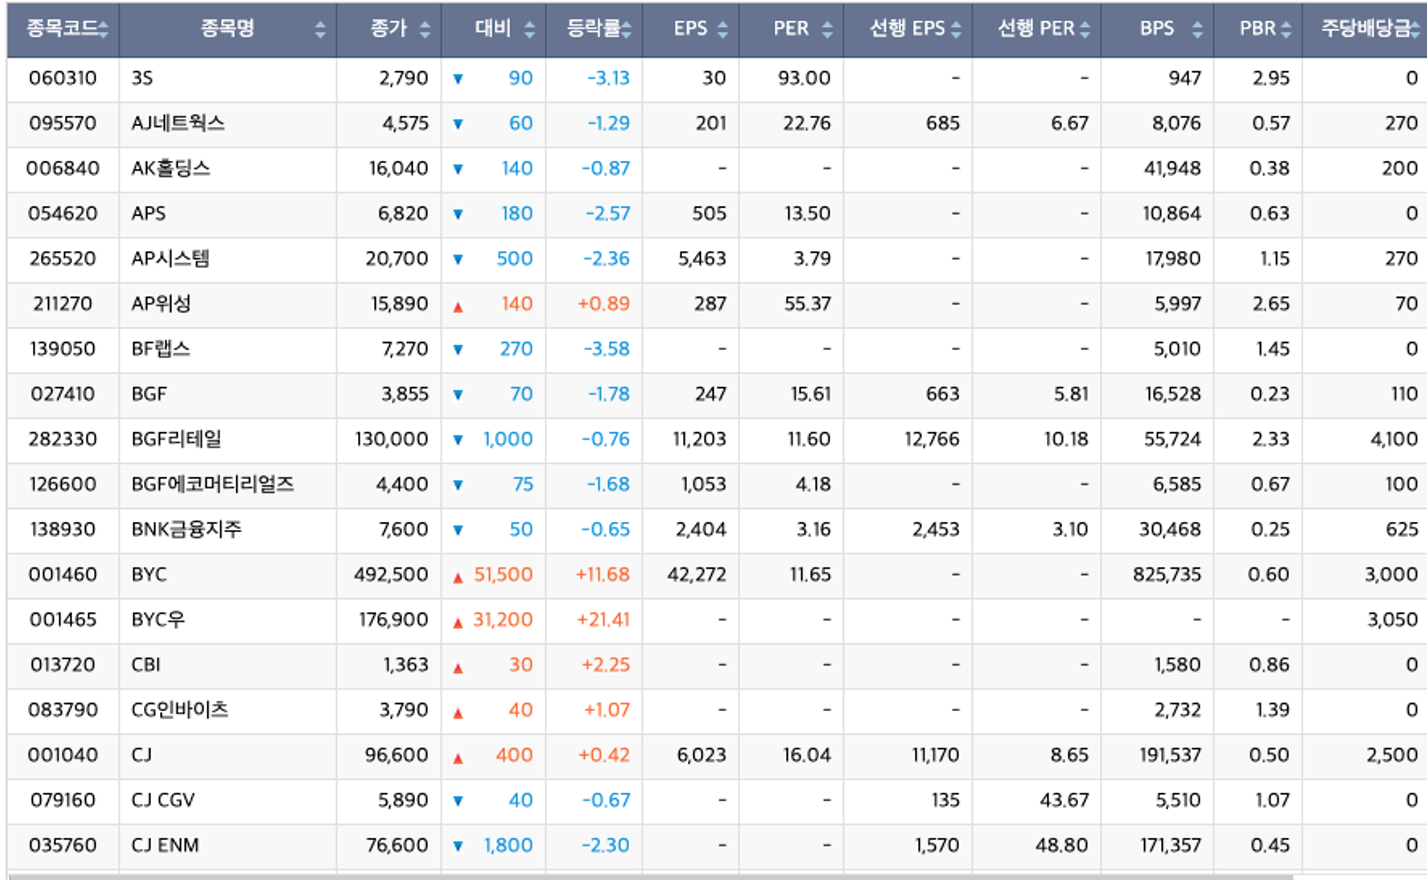

In [3]:
from PIL import Image
image_path = 'profit_table.png'
Image.open(image_path)

## 2. Converse API를 이용한 Text 및 table 이미지 테스트
- https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference.html#message-inference-examples

In [4]:
%%time
prompt = "나는 인공지능 AI 보험 서비스입니다. 생명과 손해 보험의 차이에 대해 설명해 주세요."
message = [{"role": "user", "content": [{"text": prompt}]}]

# response = output_claude_converse_stream(message, model='sonnet')  ## stream
response = output_claude_converse(message, model='sonnet') 

Role: assistant
Text: 생명보험과 손해보험은 보험의 주요 유형으로 다음과 같은 차이점이 있습니다.

1. 보상 대상
- 생명보험은 사람의 생명과 관련된 위험을 보장합니다. 예를 들어 사망, 상해, 질병 등을 대상으로 합니다.
- 손해보험은 재산상의 경제적 손실을 보상합니다. 화재, 교통사고, 배상책임 등으로 인한 재물 손해를 보장합니다.

2. 보험금 지급 원인
- 생명보험은 피보험자의 사망, 상해, 질병 등 인적 위험이 발생했을 때 보험금을 지급합니다.
- 손해보험은 재물 손해나 배상책임 등의 경제적 손실이 발생했을 때 실제 입은 손해를 보상합니다.

3. 보험기간
- 생명보험은 일반적으로 장기 보험이며, 종신보험의 경우 피보험자 종신까지 보장됩니다.
- 손해보험은 단기 보험이 일반적이며, 1년 만기로 가입한 후 갱신하는 방식입니다.

4. 보험료 산정 기준
- 생명보험료는 피보험자의 나이, 건강상태, 가입금액 등 인적 요소를 주로 반영합니다.
- 손해보험료는 재물의 위험도, 가액, 업종 등 물적 요소를 주로 반영합니다.

요
Input tokens:  55
Output tokens:  512
Total tokens:  567
Stop reason: max_tokens

Finished generating text with model sonnet.
CPU times: user 166 ms, sys: 17.9 ms, total: 184 ms
Wall time: 10.2 s


In [5]:
%%time
prompt = "AP위성의 종가가 어떻게 되나요?"
message = [{
    "role": "user",
    "content": [
        { "text": "Image 1:" },
        {"image": {"format": 'png', "source": {"bytes": open_image(image_path)}}},  # 'png'|'jpeg'|'gif'|'webp'
        {"text": prompt}
    ]
}]

response = output_claude_converse_stream(message, model='sonnet')  ## stream
# response = output_claude_converse(message, model='sonnet') 


Role: assistant
AP위성의 종가는 15,890원입니다. 해당 표에서 AP위성의 종목코드는 211270이며, 해당 행의 종가 열에 15,890원이라고 기재되어 있습니다.
Finished generating text with model sonnet.
CPU times: user 39.9 ms, sys: 4.23 ms, total: 44.2 ms
Wall time: 3.89 s


In [6]:
content = """
제삼이가 곡물로 국내산 찰보리쌀 1kg을 구매하고, 영준이는 농협에서 수입산 보리쌀 2Kg과 국내산 찰보리쌀 5KG을 주문했다.
"""

message = [{
    "role": "user",
    "content": [
        { "text": f"<content>{content}</content>" },
        { "text": "Please use the cateorize_items tool to generate the item category JSON based on the content within the <content> tags." }
    ],
}]

toolConfig={
    "tools": [
    {
        "toolSpec": {
            "name": "cateorize_items",
            "description": "입력 내용을 카테고리화",
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "item_name": {
                            "type": "string",
                            "description": "예를 들어 보리쌀, 청피망 등과 같은 단일 품목의 이름 입니다."
                        },
                        "origin": {
                            "type": "string",
                            "description": "예를 들어 국내산, 수입산 또는 롯데 등과 같은 원산지 또는 제조업체 정보 입니다."
                        },
                        "unit": {
                            "type": "string",
                            "description": "예를 들어 1kg, 1k(180~230g) 등과 같은 규격에 대한 정보 입니다."
                        },
                        "description": {
                            "type": "string",
                            "description": "프롬프트에 있는 모든 정보"
                        }
                    },
                    "required": [
                        "item_name",
                        "origin",
                        "unit",
                        "description"
                    ]
                }
            }
        }
    }
]
,
    "toolChoice": {
        "tool": {
            "name": "cateorize_items"
        }
    }
}

response = output_claude_converse(message, model='sonnet', toolConfig=toolConfig) 
# response = output_claude_converse_stream(message, model='sonnet', toolConfig=toolConfig)  ## 한국어 encoding 문제

Role: assistant
toolUseId: tooluse_0IUXQ-jaSSKjUySdYrUrww
name: cateorize_items
input: {'item_name': '찰보리쌀', 'origin': '국내산', 'unit': '1kg', 'description': '제삼이가 곡물로 국내산 찰보리쌀 1kg을 구매하고'}
toolUseId: tooluse_dSQUeKNiRUuk9BjP-s9TyA
name: cateorize_items
input: {'item_name': '보리쌀', 'origin': '수입산', 'unit': '2kg', 'description': '영준이는 농협에서 수입산 보리쌀 2Kg과 국내산 찰보리쌀 5KG을 주문했다.'}
toolUseId: tooluse_5XQe8pHYS_W_XY1PCWDCMg
name: cateorize_items
input: {'item_name': '찰보리쌀', 'origin': '국내산', 'unit': '5kg', 'description': '영준이는 농협에서 수입산 보리쌀 2Kg과 국내산 찰보리쌀 5KG을 주문했다.'}
Input tokens:  974
Output tokens:  415
Total tokens:  1389
Stop reason: tool_use

Finished generating text with model sonnet.


## 3. Invoke model를 이용한 Text 및 table 이미지 테스트


In [7]:
%%time
prompt = "나는 인공지능 AI 보험 서비스입니다. 생명과 손해 보험의 차이에 대해 설명해 주세요."
message = [{"role": "user", 
            "content": [
                {"type": "text", "text": prompt},
            ]
           }]

response = bedrock_claude3(message, model='sonnet', stream=True, system=None, region_name='us-west-2')

생명보험과 손해보험은 보험의 주요 유형으로 다음과 같이 구분됩니다.

1. 생명보험
- 사람의 생명과 관련된 위험을 보장합니다. 
- 주요 종류로는 사망보험, 생존보험, 상해보험 등이 있습니다.
- 보험금 지급사유가 발생하면 가입 때 약정한 보험금을 지급합니다.
- 장기적인 위험을 대비하는 성격이 강합니다.

2. 손해보험  
- 재산상의 손해나 배상책임을 보장합니다.
- 주요 종류로는 화재보험, 배상책임보험, 종합보험 등이 있습니다. 
- 실제 입은 손해액수를 보상하는 것이 원칙입니다.
- 단기적인 위험에 대비하는 성격이 강합니다.

두 보험은 보장하는 위험의 성격, 보험금 지급방식, 가입목적 등에서 차이가 있습니다. 생명보험은 개인의 생명위험을 중심으로 하고, 손해보험은 재산상의 경제적 손해를 보상하는 데 중점을 둡니다.CPU times: user 58.6 ms, sys: 7.29 ms, total: 65.9 ms
Wall time: 6.68 s


In [8]:
%%time
prompt = "AP위성의 종가가 어떻게 되나요?"
message = [{"role": "user",
            "content": [
                {"type": "image", "source": { "type": "base64", "media_type": "image/png", "data": image_to_base64(image_path)}},  ## image/jpeg, image/webp, image/gif
                {"type": "text", "text": prompt},
            ],
           }
          ]

response = bedrock_claude3(message, 'sonnet', True)

Reading image from file: profit_table.png
AP위성의 종가는 15,890원입니다. 해당 표에서 AP위성의 종목코드는 211270이며, 종가 열에 15,890원으로 기재되어 있습니다.CPU times: user 36.5 ms, sys: 536 μs, total: 37 ms
Wall time: 3.33 s


## 4. Multi-turn을 고려한 Message 전달 방식 테스트

In [9]:
%%time
prompt1 = "나는 인공지능 AI 보험 서비스입니다. 생명과 손해 보험의 차이에 대해 설명해 주세요."
message = [
    {"role": "user", "content": [{"type": "text", "text": prompt1}]},
]

response1 = bedrock_claude3(message, 'sonnet', True)

생명보험과 손해보험은 보험의 주요 유형으로 다음과 같은 차이점이 있습니다.

1. 보장 대상
- 생명보험은 사람의 생명과 관련된 위험을 보장합니다. 예를 들어 사망, 상해, 질병 등을 대상으로 합니다.
- 손해보험은 재산상의 손해나 배상책임을 보장합니다. 화재, 자동차사고, 재해 등으로 인한 재물 손실이나 타인에게 입힌 손해를 대상으로 합니다.

2. 보험금 지급 사유
- 생명보험은 피보험자의 사망, 상해, 질병 등의 경우 보험금을 지급합니다.
- 손해보험은 보험 목적물에 손해가 발생한 경우 그 손해액을 보상합니다.

3. 보험기간
- 생명보험은 일반적으로 장기계약이며 피보험자의 생존기간 동안 유효합니다.
- 손해보험은 단기계약이 일반적이며 1년 만기로 갱신하는 경우가 많습니다.

4. 보험료 산정 기준
- 생명보험료는 피보험자의 나이, 건강상태, 가족력 등 개인 위험도에 따라 결정됩니다.
- 손해보험료는 보험 목적물의 가액, 위험률, 손해율 등에 따라 결정됩니다.

요약하면 생명보험은 개인의 생명 위험CPU times: user 66.4 ms, sys: 14.2 ms, total: 80.6 ms
Wall time: 9.89 s


In [10]:
%%time
prompt2 = "대상을 좀더 상세히 설명해 주세요"
message = [
    {"role": "user", "content": [{"type": "text", "text": prompt1}]},
    {"role": "assistant", "content": response1},
    {"role": "user", "content": [{"type": "text", "text": prompt2}]},
]

response2 = bedrock_claude3(message, 'sonnet', True)

생명보험과 손해보험의 대상을 좀 더 상세히 설명드리겠습니다.

[생명보험 대상]
- 사망 : 피보험자가 사망할 경우 유족에게 사망보험금 지급
- 상해 : 피보험자가 재해로 인한 상해를 입었을 때 보장
- 질병 : 피보험자가 특정 질병에 걸렸을 때 보장(암, 심장질환 등)
- 입원/수술 : 피보험자가 입원하거나 수술 시 보장
- 간병 : 피보험자가 중증 상태에 빠져 간병이 필요할 때 보장
- 노후소득 : 연금보험으로 노후 소득 보장

[손해보험 대상]  
- 화재보험 : 건물, 가재도구 등의 화재 손해 보장
- 배상책임보험 : 타인에게 입힌 손해에 대한 법률상 배상책임 보장
- 종합보험 : 화재, 도난, 파손 등 재물 손해 포괄 보장  
- 자동차보험 : 자동차 사고로 인한 차량 손해, 대인/대물 배상 보장
- 마린보험 : 선박, 항공기, 운송물건 등 해상 위험 보장
- 기술보험 : 기계 고장, 건설 공사 등의 위험 보장
- 상해보험 : 재해로 인한 상해 위험 보장

생명보험은 개인의 생명 및 건강 CPU times: user 73.9 ms, sys: 13.7 ms, total: 87.6 ms
Wall time: 9.88 s


In [11]:
%%time
message = [
  {"role": "user", "content": "추천 상품으로 가장 적합한 것은? A. 햄버거 B. 탕수육 C. 제육덮밥"},
  {"role": "assistant", "content": "가장 좋은 답변은 ("},
]
response = bedrock_claude3(message, 'sonnet', True)

추천 상품에 대한 더 많은 맥락이 주어지지 않았기 때문에) 제공된 옵션 중에서 선택하기 어렵습니다. 하지만 일반적으로 건강하고 균형 잡힌 식단을 권장하는 것이 좋습니다. 

햄버거는 보통 지방과 칼로리가 높고, 탕수육은 기름에 튀겨 만들어져 역시 건강에 좋지 않습니다. 제육덮밥이 가장 건강에 나은 선택일 수 있지만, 그래도 고기와 밥의 양에 따라 영양가가 달라질 수 있습니다.

이상적인 식단은 신선한 과일, 채소, 통곡물, 단백질 등 다양한 영양소를 골고루 섭취하는 것입니다. 개인의 건강 상태와 기호에 맞추어 적절히 선택하는 것이 중요합니다.CPU times: user 51.7 ms, sys: 10.6 ms, total: 62.4 ms
Wall time: 7.31 s


In [12]:
%%time
text_prompt1 = "이미지 table에서 나온 내용을 정확히 분석해서 환각이 없도록 설명해줘. CG인바이츠의 종가는 얼마야"
message = [
  {"role": "user", "content": [
      {"type": "image","source" : {"type" : "base64", "media_type": "image/png","data": image_to_base64(image_path)}}, 
      {"type": "text", "text": text_prompt1}]}
]
response1 = bedrock_claude3(message, 'sonnet', True)

Reading image from file: profit_table.png
표에 따르면 CG인바이츠의 종가는 3,790원입니다.CPU times: user 31.8 ms, sys: 536 μs, total: 32.4 ms
Wall time: 2.02 s


In [13]:
%%time
text_prompt2 = "BPS도 알려줘"
message = [
    {"role": "user", "content": [
        {"type": "image","source" : {"type" : "base64", "media_type": "image/png","data": image_to_base64(image_path)}}, 
        {"type": "text", "text": text_prompt1}]},
    {"role": "assistant", "content": response1},
    {"role": "user", "content": [{"type": "text", "text": text_prompt2}]},
]
response2 = bedrock_claude3(message, 'sonnet', True)

Reading image from file: profit_table.png
표에서 CG인바이츠의 BPS(주당순자산가치)는 2,732원으로 나와 있습니다.CPU times: user 33.9 ms, sys: 0 ns, total: 33.9 ms
Wall time: 3.04 s
